In [1]:
# Import statements
import docplex
from docplex.mp.model import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Defining the model class

In [31]:
class PSH(Model):
    # Indices
    reservoirs = np.arange(2)
    upstream_reservoirs = {
        0: [],
        1: [0],
    }
    hydro_units = np.arange(4)
    hu_affiliation = {
        0: [0,1,2,3],
        1: []
    }
    pumped_storage_units = np.arange(2)
    ps_affiliation = {
        0: [0,1],
        1: []
    }
    periods = np.arange(12)
    subregions = np.arange(10)
    vertices = np.arange(3)

    # Parameters
    initial_volume = {
        0: 1200000,
        1: 800000,
    }
    projected_prices = [40, 40, 40, 42, 51, 42, 42, 42, 41, 39, 40, 40]
    period_length = 2
    natural_inflow = pd.DataFrame(data=2, index=reservoirs, columns=periods)
    spillage = pd.DataFrame(data=1, index=reservoirs, columns=periods)
    travel_times = pd.DataFrame(data=[[0,1],[0,0]], index=reservoirs, columns=reservoirs)
    pumping_consumption = {
        0: 1,
        1: 2,
    }
    
    # Volume limits
    volume_limits = pd.DataFrame(index=['max', 'min'], columns=reservoirs)
    volume_limits.loc['max':,] = 2000000
    volume_limits.loc['min':,] = 10000

    # Pumped-storage unit pumping limits
    ps_power_pumping_limits = pd.DataFrame(index=['max', 'min'], columns=pumped_storage_units)
    ps_power_pumping_limits.loc['max':,] = 4
    ps_power_pumping_limits.loc['min':,] = 1

    ps_discharge_pumping_limits = pd.DataFrame(index=['max', 'min'], columns=pumped_storage_units)
    ps_discharge_pumping_limits.loc['max':,] = 10
    ps_discharge_pumping_limits.loc['min':,] = 1

    # Linearization
    hu_head_limits = pd.DataFrame(index=['max', 'min'], columns=hydro_units)
    hu_head_limits.loc['max':,] = 10
    hu_head_limits.loc['min':,] = 4

    hu_discharge_limits = pd.DataFrame(index=['max', 'min'], columns=hydro_units)
    hu_discharge_limits.loc['max':,] = 20
    hu_discharge_limits.loc['min':,] = 10

    ps_head_limits = pd.DataFrame(index=['max', 'min'], columns=pumped_storage_units)
    ps_head_limits.loc['max':,] = 10
    ps_head_limits.loc['min':,] = 4

    ps_discharge_generation_limits = pd.DataFrame(index=['max', 'min'], columns=pumped_storage_units)
    ps_discharge_generation_limits.loc['max':,] = 20
    ps_discharge_generation_limits.loc['min':,] = 10

    hu_h_vertices = []
    hu_q_vertices = []
    hu_p_vertices = []

    ps_h_vertices = []
    ps_q_vertices = []
    ps_p_vertices = []

    # Head Parameters
    hu_head_zero = {
        0: hu_head_limits.loc['min', 0],
        1: hu_head_limits.loc['min', 1],
        2: hu_head_limits.loc['min', 1],
        3: hu_head_limits.loc['min', 1]
    }
    hu_head_coefficient = {
        0: 0.00000302,
        1: 0.00000302,
        2: 0.00000302,
        3: 0.00000302
    }
    ps_head_zero = {
        0: ps_head_limits.loc['min', 0],
        1: ps_head_limits.loc['min', 1],
    }
    ps_head_coefficient = {
        0: 0.00000302,
        1: 0.00000302,
    }

    # Defining the rho-values to calculate the power production
    rho_values = pd.DataFrame(index=np.arange(6), columns=hydro_units)
    rho_values.loc[0:,] = 0.85
    rho_values.loc[1:,] = 0.02
    rho_values.loc[2:,] = 0.03
    rho_values.loc[3:,] = -0.0001
    rho_values.loc[4:,] = -0.0002
    rho_values.loc[5:,] = -0.00001


    def __init__(self):
        super().__init__()

    
    # Method to calculate the head vertices for the linearization
    def head_vertices(self, units: list, affiliation: dict, limits: pd.DataFrame) -> list:

        #Defining a 4-dimensional array
        vertice_values = np.zeros([len(self.reservoirs), len(units), len(self.subregions), len(self.vertices)])
        
        for i in self.reservoirs:
            for j in affiliation[i]:

                # Dividing the water head into equally large intervals, that fill the domain
                head_interval = (limits.loc['max',j] - limits.loc['min',j]) / (len(self.subregions) / 2)
                for l in self.subregions:
                    if l % 2 == 0: # Defining the coordonates of 2 trangles in 1 itteration

                        # First triangle
                        vertice_values[i,j,l,0] = limits.loc['min',j] + l / 2 * head_interval # bottom left
                        vertice_values[i,j,l,1] = limits.loc['min',j] + l / 2 * head_interval + head_interval # bottom right
                        vertice_values[i,j,l,2] = vertice_values[i,j,l,0] # top left

                        # Secon triangle
                        vertice_values[i,j,l+1,0] = vertice_values[i,j,l,0] # top left
                        vertice_values[i,j,l+1,1] = vertice_values[i,j,l,1]# top right
                        vertice_values[i,j,l+1,2] = vertice_values[i,j,l,1] # bottom right

        return vertice_values
    

    # Method to calculate the discharge vertrices for the linearization
    def discharge_vertices(self, units: list, affiliation: dict, limits: pd.DataFrame) -> list:

        #Defining a 4-dimensional array
        vertice_values = np.zeros([len(self.reservoirs), len(units), len(self.subregions), len(self.vertices)])

        for i in self.reservoirs:
            for j in affiliation[i]:
                for l in self.subregions:
                    if l % 2 == 0: # Defining the coordonates of 2 triangles in 1 itteration
                        vertice_values[i,j,l,0] = limits.loc['min',j] # bottom left
                        vertice_values[i,j,l,1] = limits.loc['min',j] # bottom right
                        vertice_values[i,j,l,2] = limits.loc['max',j] # top left

                        vertice_values[i,j,l+1,0] = limits.loc['max',j] # top left
                        vertice_values[i,j,l+1,1] = limits.loc['max',j] # top right
                        vertice_values[i,j,l+1,2] = limits.loc['min',j] # bottom right
        
        return vertice_values
    

    # Method to calculate the power vertices for the linearization
    def power_vertices(self, units: list, affiliation: dict, h_vertices: list, q_vertices: list) -> list:

        #Defining a 4-dimensional array
        vertice_values = np.zeros([len(self.reservoirs), len(units), len(self.subregions), len(self.vertices)])
        
        for i in self.reservoirs:
            for j in affiliation[i]:
                for l in self.subregions:
                    for r in self.vertices:

                        # Applying the formulas from the base paper
                        efficiency = self.rho_values.loc[0,j] + self.rho_values.loc[1,j] * h_vertices[i,j,l,r] + self.rho_values.loc[2,j] * q_vertices[i,j,l,r] + self.rho_values.loc[3,j] * (h_vertices[i,j,l,r] ** 2) + self.rho_values.loc[4,j] * (q_vertices[i,j,l,r] ** 2) + self.rho_values.loc[5,j] * h_vertices[i,j,l,r] * q_vertices[i,j,l,r]
                        vertice_values[i,j,l,r] = 981 * (10 ** -3) * efficiency * h_vertices[i,j,l,r] * q_vertices[i,j,l,r]

        return vertice_values
    

    # Method to define the decision variabels
    def define_decision_variables(self):
        self.clear()

        # Reservoir decision variables
        self.volume = self.continuous_var_matrix(self.reservoirs, self.periods, name='volume')
        self.total_discharge = self.continuous_var_matrix(self.reservoirs, self.periods, name='total_discharge')

        # Hydro unit decision variables
        self.hu_discharge = self.continuous_var_cube(self.reservoirs, self.hydro_units, self.periods, name='hu_discharge')
        self.hu_head = self.continuous_var_cube(self.reservoirs, self.hydro_units, self.periods, name='hu_head')
        self.hu_power = self.continuous_var_cube(self.reservoirs, self.hydro_units, self.periods, name='hu_power')
        self.hu_active_subregion = self.binary_var_dict([(i, j, t, l) for i in self.reservoirs for j in self.hydro_units for t in self.periods for l in self.subregions], name='hu_active_subregion')
        self.hu_alpha_coefficient = self.continuous_var_dict([(i, j, t, l, r) for i in self.reservoirs for j in self.hydro_units for t in self.periods for l in self.subregions for r in self.vertices], name='hu_alpha_coefficient')

        # Pumped-storage unit decision variables
        self.ps_active_subregion = self.binary_var_dict([(i, k, t, l) for i in self.reservoirs for k in self.pumped_storage_units for t in self.periods for l in self.subregions], name='ps_active_subregion')
        self.ps_alpha_coefficient = self.continuous_var_dict([(i, k, t, l, r) for i in self.reservoirs for k in self.pumped_storage_units for t in self.periods for l in self.subregions for r in self.vertices], name='ps_alpha_coefficient')
        self.ps_head_gen = self.continuous_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_head_gen')
        self.ps_power_gen = self.continuous_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_power_gen')
        self.ps_power_pump = self.continuous_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_power_pump')
        self.ps_discharge_gen = self.continuous_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_discharge_gen')
        self.ps_discharge_pump = self.continuous_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_discharge_pump')
        self.ps_state_gen = self.binary_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_state_gen')
        self.ps_state_pump = self.binary_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_state_pump')


    # Method that defines the constraints of the model
    def define_contraints(self):
        self.clear_constraints()

        # (2) Water-balance constraint
        for i in self.reservoirs[1:]:
            for t in self.periods[1:]:
                self.add_constraint(self.volume[i,t] == self.volume[i,t-1] + 3600 * self.period_length * (self.natural_inflow.loc[i,t] - self.total_discharge[i,t] + self.sum(self.total_discharge[m,t-self.travel_times.loc[m,i]] for m in self.upstream_reservoirs[i]) - self.sum(self.ps_discharge_pump[i-1,k,t] for k in self.ps_affiliation[i-1]) + self.sum(self.ps_discharge_pump[i,k,t] for k in self.ps_affiliation[i])))

        # Exception for first period and all reservoirs
        # for i in self.reservoirs[1:]:
        #     self.add_constraint(self.volume[i,0] == self.initial_volume + 3600 * self.period_length * (self.natural_inflow.loc[i,0] - self.total_discharge[i,0] + 0 - self.sum(self.ps_discharge_pump[i-1,k,0] for k in self.ps_affiliation[i-1]) + self.sum(self.ps_discharge_pump[i,k,0] for k in self.ps_affiliation[i]))) # There can't be inflows from upstream reservoirs in the first period

        # Exception for first reservoir and all periods
        for t in self.periods[1:]:
            self.add_constraint(self.volume[0,t] == self.volume[0,t-1] + 3600 * self.period_length * (self.natural_inflow.loc[0,t] - self.total_discharge[0,t] + 0 - 0 + self.sum(self.ps_discharge_pump[0,k,t] for k in self.ps_affiliation[0]))) # No inflow from upstream reservoirs and no pumped water to upstream reservoirs for the first reservoir
            
        # # Exception for first reservoir and period
        # self.add_constraint(self.volume[0,0] == self.initial_volume + 3600 * self.period_length * (self.natural_inflow.loc[0,0] - self.total_discharge[0,0] + 0 - 0 + self.sum(self.ps_discharge_pump[0,k,0] for k in self.ps_affiliation[0]))) # No inflow from upstream reservoirs and no pumped water to upstream reservoirs for the first reservoir

        self.add_constraint(self.volume[0,0] == self.initial_volume[0] + 3600 * self.period_length * (self.natural_inflow.loc[0,0] - self.total_discharge[0,0] + 0 - 0 + self.sum(self.ps_discharge_pump[0,k,0] for k in self.ps_affiliation[i])))
        self.add_constraint(self.volume[1,0] == self.initial_volume[1] + 3600 * self.period_length * (self.natural_inflow.loc[1,0] - self.total_discharge[1,0] + 0 - self.sum(self.ps_discharge_pump[0,k,0] for k in self.ps_affiliation[i]) + self.sum(self.ps_discharge_pump[1,k,0] for k in self.ps_affiliation[i])))


        # ----- Added Constraints -------
        # self.add_constraint(self.volume[0,9] <= 1600000)
        # self.add_constraint(self.volume[0,9] >= 800000)
        # self.add_constraint(self.volume[1,9] <= 1100000)
        # self.add_constraint(self.volume[1,9] >= 500000)
        # self.add_constraint(self.volume[1,9] <= 1300000)
        # self.add_constraint(self.volume[1,9] >= 700000)
        # self.add_constraints(self.total_discharge[i, len(self.periods) - 1] == 1 for i in self.reservoirs)


        # (3) Total discharge
        for i in self.reservoirs:
            for t in self.periods:
                self.add_constraint(self.total_discharge[i,t] == self.spillage.loc[i,t] + self.sum(self.hu_discharge[i,j,t] for j in self.hu_affiliation[i]) + self.sum(self.ps_discharge_gen[i,k,t] for k in self.ps_affiliation[i]))

        # (4) Water-level limits
        for i in self.reservoirs:
            for t in self.periods:
                self.add_constraint(self.volume[i,t] >= self.volume_limits.loc['min',i])
                self.add_constraint(self.volume[i,t] <= self.volume_limits.loc['max',i])

        # (8) At most one subregion can be active
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.sum(self.hu_active_subregion[i,j,t,l] for l in self.subregions) <= 1)

        # (9) Convex combination coefficients must sum up to 1 or 0
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    for l in self.subregions:
                        self.add_constraint(self.sum(self.hu_alpha_coefficient[i,j,t,l,r] for r in self.vertices) == self.hu_active_subregion[i,j,t,l])

        # (10) Non-negativity condition for convex combination coefficients
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    for l in self.subregions:
                        for r in self.vertices:
                            self.add_constraint(self.hu_alpha_coefficient[i,j,t,l,r] >= 0)

        # (11)-(13) Calculation of linearized water head, discharge, and power output
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.hu_head[i,j,t] == self.sum(self.sum(self.hu_alpha_coefficient[i,j,t,l,r] * self.hu_h_vertices[i,j,l,r] for r in self.vertices) for l in self.subregions)) # (11) water head
                    self.add_constraint(self.hu_discharge[i,j,t] == self.sum(self.sum(self.hu_alpha_coefficient[i,j,t,l,r] * self.hu_q_vertices[i,j,l,r] for r in self.vertices) for l in self.subregions)) # (12) discharge
                    self.add_constraint(self.hu_power[i,j,t] == self.sum(self.sum(self.hu_alpha_coefficient[i,j,t,l,r] * self.hu_p_vertices[i,j,l,r] for r in self.vertices) for l in self.subregions)) # (13) power

        # (14) Relation between water head and volume
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.hu_head[i,j,t] <= self.hu_head_zero[j] + self.hu_head_coefficient[j] * self.volume[i,t])

        # ----- Modified constraints (8)-(14) for pumped-storage units -----
        # At most one subregion can be active
        for i in self.reservoirs:
            for j in self.ps_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.sum(self.ps_active_subregion[i,j,t,l] for l in self.subregions) <= 1)

        # Convex combination coefficients must sum up to 1 or 0
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:
                    for l in self.subregions:
                        self.add_constraint(self.sum(self.ps_alpha_coefficient[i,k,t,l,r] for r in self.vertices) == self.ps_active_subregion[i,k,t,l])

        # Non-negativity condition for convex combination coefficients
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:
                    for l in self.subregions:
                        for r in self.vertices:
                            self.add_constraint(self.ps_alpha_coefficient[i,k,t,l,r] >= 0)

        # Calculation of linearized water head, discharge, and power output
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.ps_head_gen[i,k,t] == self.sum(self.sum(self.ps_alpha_coefficient[i,k,t,l,r] * self.ps_h_vertices[i,k,l,r] for r in self.vertices) for l in self.subregions)) # water head
                    self.add_constraint(self.ps_discharge_gen[i,k,t] == self.sum(self.sum(self.ps_alpha_coefficient[i,k,t,l,r] * self.ps_q_vertices[i,k,l,r] for r in self.vertices) for l in self.subregions)) # discharge
                    self.add_constraint(self.ps_power_gen[i,k,t] == self.sum(self.sum(self.ps_alpha_coefficient[i,k,t,l,r] * self.ps_p_vertices[i,k,l,r] for r in self.vertices) for l in self.subregions)) # power

        # Relation between water head and volume
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.ps_head_gen[i,k,t] <= self.ps_head_zero[k] + self.ps_head_coefficient[k] * self.volume[i,t])

        # ----- End modified constraints (8)-(14) for pumped-storage units -----

        # (16)-(22) Pumped storage unit constraints
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:

                    # (15) state constraint
                    self.add_constraint(self.ps_state_gen[i,k,t] + self.ps_state_pump[i,k,t] <= 1)

                    # (16) Pumping constraints
                    self.add_constraint(self.ps_discharge_pumping_limits.loc['min',k] * self.ps_state_pump[i,k,t] <= self.ps_discharge_pump[i,k,t])
                    self.add_constraint(self.ps_discharge_pumping_limits.loc['max',k] * self.ps_state_pump[i,k,t] >= self.ps_discharge_pump[i,k,t])


                    self.add_constraint(self.ps_power_gen[i,k,t] <= self.ps_state_gen[i,k,t] * 10000000)


                    # (17) Calculating power consumption based on pumped water
                    self.add_constraint(self.ps_power_pump[i,k,t] == self.ps_discharge_pump[i,k,t] * self.pumping_consumption[k])


    # Method to define the objective value and to solve the model
    def solve_model(self):
        J = self.sum(self.sum(self.projected_prices[t] * self.period_length * (self.sum(self.hu_power[i,j,t] for j in self.hu_affiliation[i]) + self.sum(self.ps_power_gen[i,k,t] for k in self.ps_affiliation[i]) - self.sum(self.ps_power_pump[i,k,t] for k in self.ps_affiliation[i])) for i in self.reservoirs) for t in self.periods)
        self.maximize(J)
        self.solve()
        

#### Validation the correct calculation of the vertices for the linearization

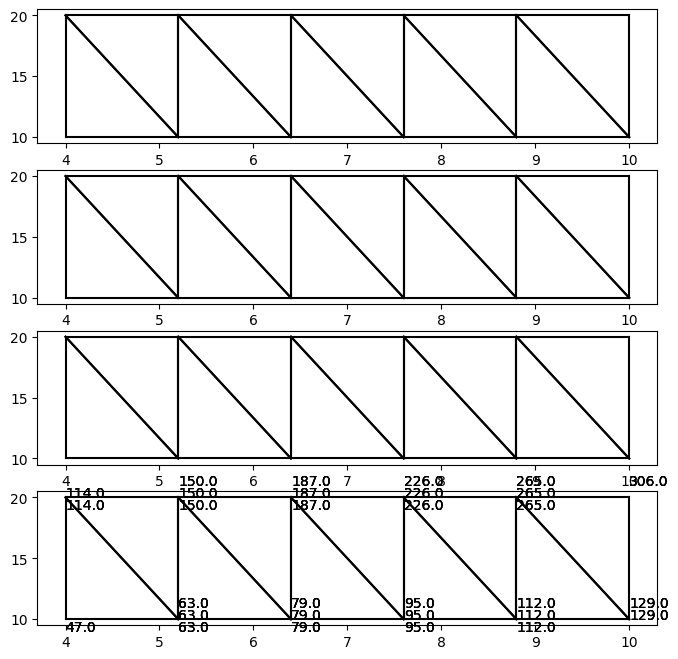

In [32]:
# Creating a model instance
psh = PSH()
psh.hu_h_vertices = psh.head_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_head_limits)
psh.hu_q_vertices = psh.discharge_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_discharge_limits)
psh.hu_p_vertices = psh.power_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_h_vertices, psh.hu_q_vertices)

psh.ps_h_vertices = psh.head_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_head_limits)
psh.ps_q_vertices = psh.discharge_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_discharge_generation_limits)
psh.ps_p_vertices = psh.power_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_h_vertices, psh.ps_q_vertices)

fig, ax = plt.subplots(nrows=len(psh.hydro_units), ncols=1, figsize=(8,8))
for j in psh.hydro_units:
    for l in psh.subregions:
        ax[j].plot([psh.hu_h_vertices[0,j,l,0], psh.hu_h_vertices[0,j,l,1]], [psh.hu_q_vertices[0,j,l,0], psh.hu_q_vertices[0,j,l,1]], color='black')
        ax[j].plot([psh.hu_h_vertices[0,j,l,1], psh.hu_h_vertices[0,j,l,2]], [psh.hu_q_vertices[0,j,l,1], psh.hu_q_vertices[0,j,l,2]], color='black')
        ax[j].plot([psh.hu_h_vertices[0,j,l,2], psh.hu_h_vertices[0,j,l,0]], [psh.hu_q_vertices[0,j,l,2], psh.hu_q_vertices[0,j,l,0]], color='black')

        plt.annotate(round(psh.hu_p_vertices[0,j,l,0],0), xy=(psh.hu_h_vertices[0,j,l,0], psh.hu_q_vertices[0,j,l,0]), xytext=(psh.hu_h_vertices[0,j,l,0], psh.hu_q_vertices[0,j,l,0]-1))
        plt.annotate(round(psh.hu_p_vertices[0,j,l,1],0), xy=(psh.hu_h_vertices[0,j,l,1], psh.hu_q_vertices[0,j,l,1]), xytext=(psh.hu_h_vertices[0,j,l,1], psh.hu_q_vertices[0,j,l,1]+1))
        plt.annotate(round(psh.hu_p_vertices[0,j,l,2],0), xy=(psh.hu_h_vertices[0,j,l,2], psh.hu_q_vertices[0,j,l,2]), xytext=(psh.hu_h_vertices[0,j,l,2], psh.hu_q_vertices[0,j,l,2]))

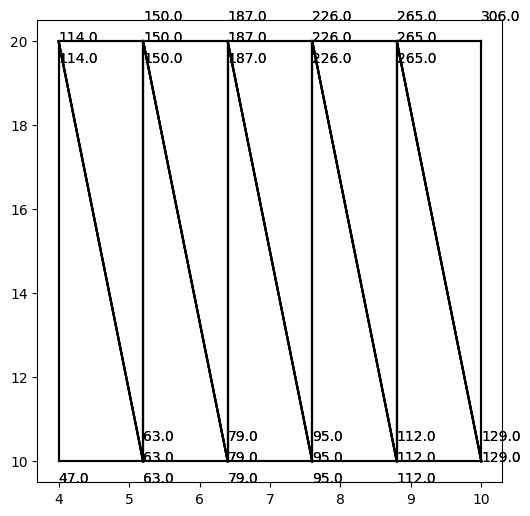

In [33]:
# Creating a model instance
psh = PSH()
psh.hu_h_vertices = psh.head_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_head_limits)
psh.hu_q_vertices = psh.discharge_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_discharge_limits)
psh.hu_p_vertices = psh.power_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_h_vertices, psh.hu_q_vertices)

psh.ps_h_vertices = psh.head_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_head_limits)
psh.ps_q_vertices = psh.discharge_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_discharge_generation_limits)
psh.ps_p_vertices = psh.power_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_h_vertices, psh.ps_q_vertices)

fig, ax = plt.subplots(figsize=(6,6))
for j in psh.pumped_storage_units:
    for l in psh.subregions:
        ax.plot([psh.ps_h_vertices[0,j,l,0], psh.ps_h_vertices[0,j,l,1]], [psh.ps_q_vertices[0,j,l,0], psh.ps_q_vertices[0,j,l,1]], color='black')
        ax.plot([psh.ps_h_vertices[0,j,l,1], psh.ps_h_vertices[0,j,l,2]], [psh.ps_q_vertices[0,j,l,1], psh.ps_q_vertices[0,j,l,2]], color='black')
        ax.plot([psh.ps_h_vertices[0,j,l,2], psh.ps_h_vertices[0,j,l,0]], [psh.ps_q_vertices[0,j,l,2], psh.ps_q_vertices[0,j,l,0]], color='black')

        plt.annotate(round(psh.ps_p_vertices[0,j,l,0],0), xy=(psh.ps_h_vertices[0,j,l,0], psh.ps_q_vertices[0,j,l,0]), xytext=(psh.ps_h_vertices[0,j,l,0], psh.ps_q_vertices[0,j,l,0]-0.5))
        plt.annotate(round(psh.ps_p_vertices[0,j,l,1],0), xy=(psh.ps_h_vertices[0,j,l,1], psh.ps_q_vertices[0,j,l,1]), xytext=(psh.ps_h_vertices[0,j,l,1], psh.ps_q_vertices[0,j,l,1]+0.5))
        plt.annotate(round(psh.ps_p_vertices[0,j,l,2],0), xy=(psh.ps_h_vertices[0,j,l,2], psh.ps_q_vertices[0,j,l,2]), xytext=(psh.ps_h_vertices[0,j,l,2], psh.ps_q_vertices[0,j,l,2]))

## Solving the model

In [34]:
psh = PSH()
psh.hu_h_vertices = psh.head_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_head_limits)
psh.hu_q_vertices = psh.discharge_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_discharge_limits)
psh.hu_p_vertices = psh.power_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_h_vertices, psh.hu_q_vertices)

psh.ps_h_vertices = psh.head_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_head_limits)
psh.ps_q_vertices = psh.discharge_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_discharge_generation_limits)
psh.ps_p_vertices = psh.power_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_h_vertices, psh.ps_q_vertices)

psh.define_decision_variables()
psh.define_contraints()
psh.solve_model()
print(psh.solve_details)
print(psh.objective_value)


status  = integer optimal, tolerance
time    = 147.351 s.
problem = MILP
gap     = 0.00999769%

293130.0563021419


## Analyzing the Data

#### Volume and discharge Data

In [87]:
v = pd.DataFrame(index=psh.reservoirs, columns=psh.periods)
for i in psh.reservoirs:
    for t in psh.periods:
        v.loc[i,t] = psh.volume[i,t].solution_value

v

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1018000.0,1036000.0,1054000.0,1072000.0,1090000.0,1108000.0,1126000.0,1144000.0,1162000.0,1180000.0,...,1270000.0,1288000.0,1306000.0,1324000.0,1270000.0,1216000.0,1090000.0,1036000.0,982000.0,1000000.0
1,1003600.0,1010800.0,1018000.0,1025200.0,1032400.0,1039600.0,1046800.0,1054000.0,1061200.0,1068400.0,...,1104400.0,1111600.0,1118800.0,1126000.0,1133200.0,611200.0,690400.0,841600.0,920800.0,1000000.0


In [88]:
d = pd.DataFrame(index=psh.reservoirs, columns=psh.periods)
for i in psh.reservoirs:
    for t in psh.periods:
        d.loc[i,t] = psh.total_discharge[i,t].solution_value

d

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,21.0,21.0,41.0,21.0,21.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [89]:
pd.DataFrame(data=[[psh.hu_discharge[0,0,t].solution_value for t in psh.periods]], columns=psh.periods)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0,0,0,0,0,5.684342e-14,0,0,0,0,...,0,-1.023182e-12,0,0,0,20.0,20.0,20.0,20.0,0


In [90]:
pd.DataFrame(data=[[psh.hu_discharge[0,1,t].solution_value for t in psh.periods]], columns=psh.periods)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,20.0,0,0,0,0,0


In [91]:
pd.DataFrame(data=[[psh.ps_discharge_gen[0,0,t].solution_value for t in psh.periods]], columns=psh.periods)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,20.0,0,0,0


In [92]:
pd.DataFrame(data= [[psh.ps_discharge_pump[0,0,t].solution_value for t in psh.periods]],columns=psh.periods)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0


#### Power 

In [93]:
pd.DataFrame(data=[[psh.hu_power[0,0,t].solution_value for t in psh.periods]], columns=psh.periods)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,228.2267,215.940089,210.674398,205.426606,0


In [94]:
pd.DataFrame(data=[[psh.hu_power[0,1,t].solution_value for t in psh.periods]], columns=psh.periods)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,233.53631,0,0,0,0,0


In [95]:
pd.DataFrame(data=[[psh.ps_power_gen[0,0,t].solution_value for t in psh.periods]], columns=psh.periods)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,215.940089,0,0,0


#### head

In [96]:
pd.DataFrame(data=[[psh.hu_head[0,0,t].solution_value for t in psh.periods]], columns=psh.periods)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,7.67232,7.2918,7.12872,6.96564,0


In [97]:
pd.DataFrame(data=[[psh.hu_head[0,1,t].solution_value for t in psh.periods]], columns=psh.periods)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,7.8354,0,0,0,0,0


In [98]:
pd.DataFrame(data=[[psh.ps_head_gen[0,0,t].solution_value for t in psh.periods]], columns=psh.periods)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7.2918,0,0,0


#### Alphas

In [99]:
x = np.zeros([len(psh.hydro_units), len(psh.periods), len(psh.subregions), len(psh.vertices)])
for j in psh.hydro_units:
    for t in psh.periods:
        for l in psh.subregions:
            for r in psh.vertices:
                x[j,t,l,r] = psh.hu_alpha_coefficient[0,j,t,l,r].solution_value

x

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 

In [100]:
x = np.zeros([len(psh.pumped_storage_units), len(psh.periods), len(psh.subregions), len(psh.vertices)])
for k in psh.pumped_storage_units:
    for t in psh.periods:
        for l in psh.subregions:
            for r in psh.vertices:
                x[k,t,l,r] = psh.ps_alpha_coefficient[0,k,t,l,r].solution_value

x

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]])

#### Results Table

In [35]:
results = pd.DataFrame(columns=psh.periods)

for j in psh.hydro_units:
    for i in psh.reservoirs:
        if j in psh.hu_affiliation[i]:
            for t in psh.periods:
                index = f'hu_discharge_{i}_{j}'
                results.loc[index,t] = psh.hu_discharge[i,j,t].solution_value

for k in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if k in psh.ps_affiliation[i]:
            for t in psh.periods:
                index = f'ps_discharge_gen_{i}_{k}'
                results.loc[index,t] = psh.ps_discharge_gen[i,k,t].solution_value

for i in psh.reservoirs:
    for t in psh.periods:
        index = f'total_discharge_{i}'
        results.loc[index,t] = psh.total_discharge[i,t].solution_value

for k in psh.pumped_storage_units:
    for i in psh.reservoirs:
            if k in psh.ps_affiliation[i]:
                for t in psh.periods:
                    index = f'ps_inflow_pump_{i}_{k}'
                    results.loc[index,t] = psh.ps_discharge_pump[i,k,t].solution_value

for k in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if i > 0:
            if k in psh.ps_affiliation[i-1]:
                for t in psh.periods:
                    index = f'ps_discharge_pump_{i}_{k}'
                    results.loc[index,t] = psh.ps_discharge_pump[i-1,k,t].solution_value

for i in psh.reservoirs:
    for t in psh.periods:
        index = f'spillage_{i}'
        results.loc[index] = psh.spillage.loc[i,t]

for i in psh.reservoirs:
    for t in psh.periods:
        index = f'natural_inflow_{i}'
        results.loc[index] = psh.natural_inflow.loc[i,t]

for i in psh.reservoirs[1:]:
    for t in psh.periods[1:]:
        index = f'inflow_upstream_{i}'
        results.loc[index,t] = psh.total_discharge[i-1,t-psh.travel_times.loc[i-1,i]].solution_value

for j in psh.hydro_units:
    for i in psh.reservoirs:
        if j in psh.hu_affiliation[i]:
            for t in psh.periods:
                index = f'hu_head_{i}_{j}'
                results.loc[index,t] = psh.hu_head[i,j,t].solution_value

for j in psh.hydro_units:
    for i in psh.reservoirs:
        if j in psh.hu_affiliation[i]:
            for t in psh.periods:
                index = f'hu_power_{i}_{j}'
                results.loc[index,t] = psh.hu_power[i,j,t].solution_value

for j in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if j in psh.ps_affiliation[i]:
            for t in psh.periods:
                index = f'ps_head_{i}_{j}'
                results.loc[index,t] = psh.ps_head_gen[i,j,t].solution_value

for j in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if j in psh.ps_affiliation[i]:
            for t in psh.periods:
                index = f'ps_power_gen_{i}_{j}'
                results.loc[index,t] = psh.ps_power_gen[i,j,t].solution_value

for j in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if j in psh.ps_affiliation[i]:
            for t in psh.periods:
                index = f'ps_power_pump_{i}_{j}'
                results.loc[index,t] = psh.ps_power_pump[i,j,t].solution_value

for i in psh.reservoirs:
    for t in psh.periods:
        index = f'volume_{i}'
        results.loc[index,t] = psh.volume[i,t].solution_value

for k in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if k in psh.ps_affiliation[i]:
            for t in psh.periods:
                index = f'ps_state_gen_{i}_{k}' 
                results.loc[index,t] = psh.ps_state_gen[i,k,t].solution_value

for k in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if k in psh.ps_affiliation[i]:
            for t in psh.periods:
                index = f'ps_state_pump_{i}_{k}' 
                results.loc[index,t] = psh.ps_state_pump[i,k,t].solution_value

for j in psh.hydro_units:
    for i in psh.reservoirs:
        if j in psh.hu_affiliation[i]:
            for t in psh.periods:
                index = f'hu_active_subregions_{i}_{j}'
                results.loc[index,t] = [int(psh.hu_active_subregion[i,j,t,l].solution_value) for l in psh.subregions]

for k in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if k in psh.ps_affiliation[i]:
            for t in psh.periods:
                index = f'ps_active_subregions_{i}_{k}'
                results.loc[index,t] = [int(psh.ps_active_subregion[i,k,t,l].solution_value) for l in psh.subregions]

for j in psh.hydro_units:
    for i in psh.reservoirs:
        if j in psh.hu_affiliation[i]:
            for t in psh.periods:
                for l in psh.subregions:
                    if psh.hu_active_subregion[i,j,t,l].solution_value == 1:
                        index = f'hu_alpha_{i}_{j}'
                        results.loc[index,t] = [round(psh.hu_alpha_coefficient[i,j,t,l,r].solution_value,2) for r in psh.vertices]

for k in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if k in psh.ps_affiliation[i]:
            for t in psh.periods:
                for l in psh.subregions:
                    if psh.ps_active_subregion[i,k,t,l].solution_value == 1:
                        index = f'ps_alpha_{i}_{k}'
                        results.loc[index,t] = [round(psh.ps_alpha_coefficient[i,k,t,l,r].solution_value,2) for r in psh.vertices]

pd.set_option('display.max_rows', None)
results

,0,1,2,3,4,5,6,7,8,9,10,11
hu_discharge_0_0,-0.0,0,-0.0,-0.0,20.0,0.0,20.0,20.0,20.0,20.0,20.0,20.0
hu_discharge_0_1,0,0,0,0,0,0,0,20.0,0,20.0,20.0,20.0
hu_discharge_0_2,0,0,0,0,0,0,0,0,20.0,17.277778,20.0,20.0
hu_discharge_0_3,0,0,0,0,20.0,0,0,0,20.0,20.0,20.0,20.0
ps_discharge_gen_0_0,0,0,0,0,0,0,0,0,0,0,0,0
ps_discharge_gen_0_1,0,0,0,0,0,0,0,0,0,0,0,0
total_discharge_0,1.0,1.0,1.0,1.0,41.0,1.0,21.0,41.0,61.0,78.277778,81.0,81.0
total_discharge_1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ps_inflow_pump_0_0,0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
ps_inflow_pump_0_1,0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0


## Plotting the Data

#### Discharge

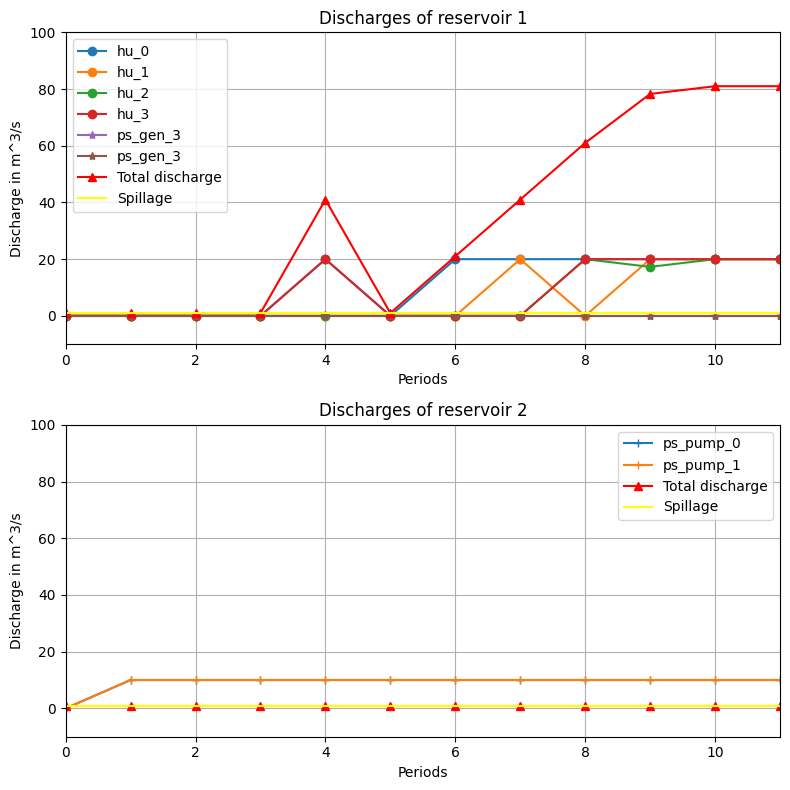

In [51]:
fig, ax = plt.subplots(nrows=len(psh.reservoirs), ncols=1, figsize=(8,8))

for i in psh.reservoirs:
    for j in psh.hu_affiliation[i]:
        ax[i].plot(psh.periods, results.loc[f'hu_discharge_{i}_{j}'], marker='o', label=f'hu_{j}')

    for k in psh.ps_affiliation[i]:
        ax[i].plot(psh.periods, results.loc[f'ps_discharge_gen_{i}_{k}'], marker='*', label=f'ps_gen_{j}')

    if i > 0:
        for k in psh.ps_affiliation[i-1]:
            ax[i].plot(psh.periods, results.loc[f'ps_discharge_pump_{i}_{k}'], marker='+', label=f'ps_pump_{k}')

    ax[i].plot(psh.periods, results.loc[f'total_discharge_{i}'], label=f'Total discharge', marker='^', color='red')
    ax[i].plot(psh.periods, results.loc[f'spillage_{i}'], label=f'Spillage', color='yellow')

    ax[i].set_title(f'Discharges of reservoir {i+1}')
    ax[i].set_ylabel('Discharge in m^3/s')
    ax[i].set_xlabel('Periods')

    ax[i].set_xlim(0, len(psh.periods)-1)
    ax[i].set_ylim(-10, 100)
    ax[i].grid()
    ax[i].legend()

plt.tight_layout()

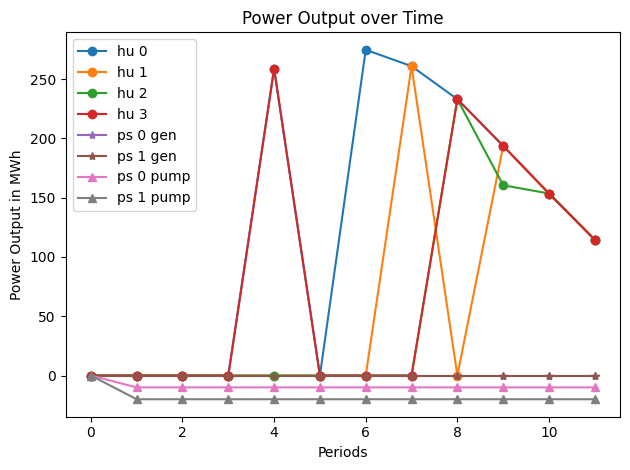

In [50]:
fig, ax = plt.subplots()

for i in psh.reservoirs:
    if i < len(psh.reservoirs)-1:
        for j in psh.hu_affiliation[i]:
            power = [psh.hu_power[i,j,t].solution_value for t in psh.periods]
            ax.plot(psh.periods, power, label=f'hu {j}', marker='o')
        
        for k in psh.ps_affiliation[i]:
            power = [psh.ps_power_gen[i,k,t].solution_value for t in psh.periods]
            ax.plot(psh.periods, power, label=f'ps {k} gen', marker='*')

        for k in psh.ps_affiliation[i]:
            power = [psh.ps_power_pump[i,k,t].solution_value * (-1) for t in psh.periods]
            ax.plot(psh.periods, power, label=f'ps {k} pump', marker='^') 

        ax.set_title('Power Output over Time')
        ax.set_ylabel('Power Output in MWh')
        ax.set_xlabel('Periods')
        ax.legend()

plt.tight_layout()

Text(0.5, 0, 'Projected Price')

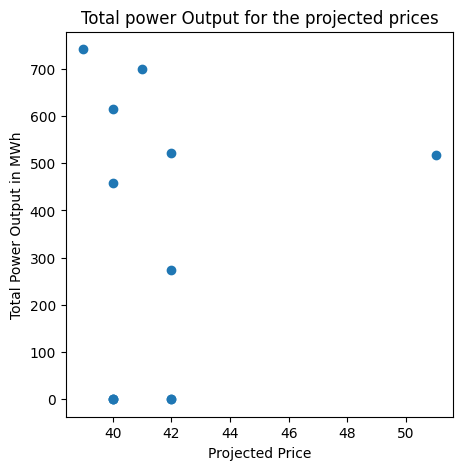

In [38]:
fig, ax = plt.subplots(figsize=(5,5))

power = []

for t in psh.periods:
    power_sum = 0
    for i in psh.reservoirs:
        for j in psh.hu_affiliation[i]:
            power_sum += psh.hu_power[i,j,t].solution_value

        for k in psh.ps_affiliation[i]:
            power_sum += psh.ps_power_gen[i,k,t].solution_value

    power.append(power_sum)

ax.scatter(psh.projected_prices, power)

ax.set_title('Total power Output for the projected prices')
ax.set_ylabel('Total Power Output in MWh')
ax.set_xlabel('Projected Price')

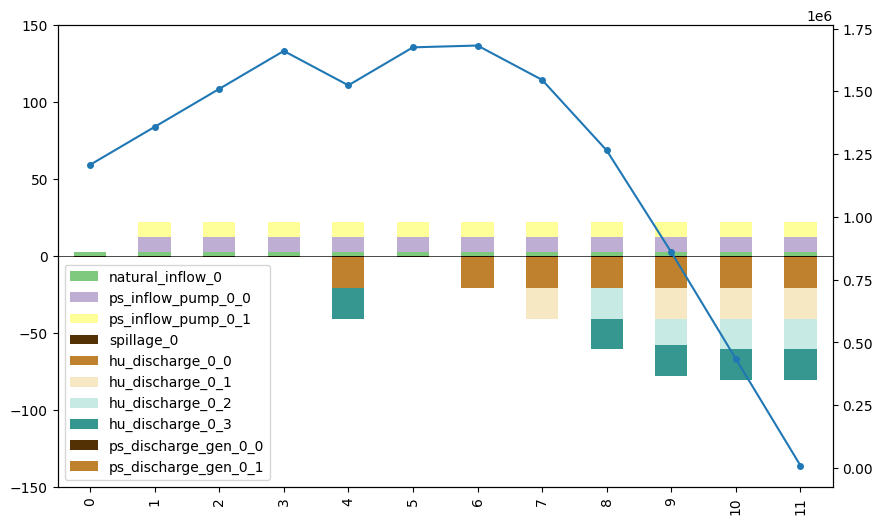

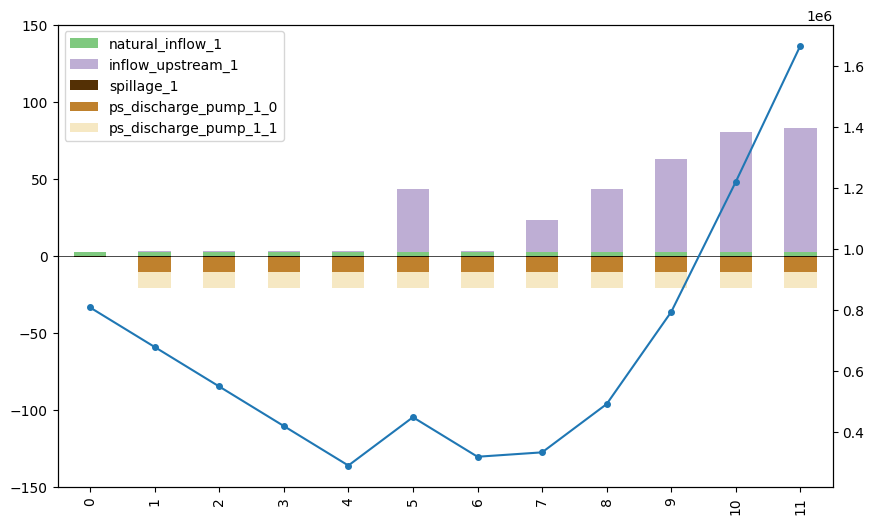

In [39]:
for i in psh.reservoirs:
    results_filtered_pos = pd.DataFrame()
    results_filtered_pos[f'natural_inflow_{i}'] = results.loc[f'natural_inflow_{i}']
    for k in psh.ps_affiliation[i]:
        results_filtered_pos[f'ps_inflow_pump_{i}_{k}'] = results.loc[f'ps_inflow_pump_{i}_{k}']
    if i > 0:
        results_filtered_pos[f'inflow_upstream_{i}'] = results.loc[f'inflow_upstream_{i}']

    results_filtered_neg = pd.DataFrame()
    results_filtered_neg[f'spillage_{i}'] = results.loc[f'spillage_{i}']
    for j in psh.hu_affiliation[i]:
        results_filtered_neg[f'hu_discharge_{i}_{j}'] = results.loc[f'hu_discharge_{i}_{j}']
    for k in psh.ps_affiliation[i]:
        results_filtered_neg[f'ps_discharge_gen_{i}_{k}'] = results.loc[f'ps_discharge_gen_{i}_{k}']
    if i > 0:
        for k in psh.ps_affiliation[i-1]:    
            results_filtered_neg[f'ps_discharge_pump_{i}_{k}'] = results.loc[f'ps_discharge_pump_{i}_{k}']
    
    results_filtered_neg = results_filtered_neg * (-1)

    colormap = plt.get_cmap('Accent')
    colors_pos = colormap(np.arange(0,1,0.2))
    colormap = plt.get_cmap('BrBG')
    colors_neg = colormap(np.arange(0,1,0.2))

    fig, ax = plt.subplots(figsize=(10,6))
    results_filtered_pos.plot(kind='bar', stacked=True, ax=ax, color=colors_pos)
    results_filtered_neg.plot(kind='bar', stacked=True, ax=ax, color=colors_neg)
    ax.axhline(y=0, color='black', linewidth=0.5)

    ax.set_ylim(-150, 150)
    
    ax2 = ax.twinx()
    results.T[f'volume_{i}'].plot(kind='line', ax=ax2, marker='o', markersize=4)